**Creating a simple neural network for regression**


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
"""
nx is the number of neurons in the input layer (i.e., the number of features in the dataset)
nh is the number of neurons in the hidden layer
ny is the number of neurons in the output layer (For this example we are using one nueron in the output layer so ny=1)
"""
def initialize_parameters(nx,nh,ny):
    #set tensorflow global random seed
    tf.random.set_seed(1)

    #initialize weights to small random numbers and biases to zeros for each layer. Note that weights and biases are defined as tensorflow variables instead of numpy arrays
    W1=tf.Variable(tf.random.uniform(shape=(nh,nx), minval=-0.01, maxval=0.01), name="W1")
    b1=tf.Variable(tf.zeros(shape=(nh,1),name="b1" ))
    W2=tf.Variable(tf.random.uniform(shape=(ny,nh), minval=-0.01, maxval=0.01), name="W2")
    b2=tf.Variable(tf.zeros(shape=(ny,1), name="b2"))

    #create a dictionary of network parameters
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [ ]:
"""
In forward pass we do the computations in the computational graph. We cache the intermediate nodes we will later need in the backward pass
"""
def forward_pass(parameters,X):
    #the input image is read as an integer, use tf.cast to cast it to float before using it in fowrard pass computation.
    X= tf.cast(X, tf.float32)
    Z1= tf.matmul(parameters["W1"],X)+ parameters["b1"] # b1 is broadcasted n times before it is added to
    A1=tf.nn.relu(Z1)
    Z2=tf.matmul(parameters["W2"],A1)+parameters["b2"] #b2 is broadcasted n times before it is added to np.dpt(W2,A1)

    Yhat=Z2

    return Yhat


In [ ]:

def compute_loss(Y, Yhat):

    """Calculates Mean Squared Error loss for regression.

    Args:
        Y: Actual/observed output values
        Yhat: Predicted output values

    Returns:
        MSE loss tensor.
    """

    squared_errors = tf.square(Y - Yhat)
    loss = tf.reduce_mean(squared_errors)
    return loss

In [ ]:
def backward_pass(parameters, loss, tape):
    gradients= tape.gradient(loss,parameters)
    return gradients


In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"].assign_sub(learning_rate*gradients["W1"])
    parameters["W2"].assign_sub(learning_rate*gradients["W2"])
    parameters["b1"].assign_sub(learning_rate*gradients["b1"])
    parameters["b2"].assign_sub(learning_rate*gradients["b2"])
    return parameters

In [ ]:
"""
Arguments: train_X: is the training dataset (features)
           train_Y: is the vector of labels for training_X
           val_X: is the vector of validation dataset (features)
           val_y: is the vector of labels for val_X
           nh: is the number of neurons in the hidden layer
           num_iterations: The number of iterations of gradient descent
"""
def create_nn_model(train_X,train_Y,nh, val_X, val_Y, num_iterations, learning_rate):
    """
    Do some safety check on the data before proceeding.
    train_X and val_X must have the same number of features (i.e., same number of rows)
    train_X must have the same number of examples as train_Y (i.e., same number of columns )
    val_X must have the same number of examples as Val_Y
    """
    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.size), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.size), "val_X and val_Y must have the same number of examples"


    #getting the number of features
    nx=train_X.shape[0]

    # We want to use this network for binary classification, so we have only one neuron in the output layer with a sigmoid activation
    ny=1

    # initializing the parameteres
    parameters=initialize_parameters(nx,nh,ny)


    #initialize lists to store the training and valideation losses.
    val_losses=[]
    train_losses=[]

    #run num_iterations of gradient descent
    for i in range (0, num_iterations):

      """
        run forward pass and compute the loss function on training and validation data.
        Note that the forward pass and loss computations on the training data are enclosed inside the gradient tape context in order to build the computational graph.
        The gradients are only computed on the training data and used to update the parameter. Validation data is not used for training and updating the parameters.
        """

      with tf.GradientTape() as tape:
        #run the forward pass on train_X
        train_Yhat=forward_pass(parameters,train_X)
        #compute the train_loss
        train_loss=compute_loss(train_Y,train_Yhat)


       #compute validation loss
      Yhat_val= forward_pass(parameters,val_X)
      val_loss=compute_loss(val_Y,Yhat_val)

      #print the trianing loss and validation loss for each iteration.
      print("iteration {} :train_loss:{} val_loss{}".format(i,train_loss,val_loss))

       # append the train and validation loss for the current iteration to the train_losses and val_losses
      train_losses.append(train_loss)
      val_losses.append(val_loss)

      """
      Compute the gradients and update the parameters
      """
      #compute the gradients on the training data
      gradients=backward_pass(parameters,train_loss,tape)

      # update the parameters
      parameters=update_parameters(parameters, gradients, learning_rate)



    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_losses,
             "train_loss": train_losses}


    #return the parameters and the history
    return parameters, history


2. **Preparing California Housing Data (4pts)**

Once you modified your network apply it to California Housing Dataset to predict the median house value.

California housing dataset is already included as a sample dataset in Google Colab. Once in Colab, click on “files” on the left hand side and you will see California_housing_train.csv and california_housing_test.csv files.

Import patndas and use pd.read_csv to read the train and test files. For example:
train=pd.read_csv("sample_data/california_housing_train.csv")
Before training your neural network with this data, you will have to do some preprocessing:


*   Split the training data into 80% training and 20% validation. There are several ways to do this; for instance, you can use dataframe sample method


> We will use the train data to build our model. Validation data to select and tune hyper- parameters and the test data for the final evaluation of the model after hyperparameters are selected.



*   Convert the train/validation/and test data into numpy arrays using to_numpy method.
*   Separate the features from the target variable (median_house_value) in train, validation, and test datasets.
*   It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization:



> for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in numpy using the mean and std methods to get the mean and standard deviation of each column in a numpy array. Make sure that you use the mean and std of the training data to normalize the validation and test data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.


*   The target variable “median_house_value” has a large range from 17K-500K. Large target values can make the loss gradient large which results in large updates to the parameters possibly making the gradient descent algorithm unstable and fluctuating. Let’s divide the median_house_values by 100K to scale them down.
*   The neural network we implemented in the lab uses the transpose of the features matrix where rows represent features and columns represent data points. Transpose the feature matrices for train/validation/and test data and reshape their target vectors to 2D arrays similar to what we did in the lab.




In [ ]:
# Load the data
train_data = pd.read_csv("sample_data/california_housing_train.csv")


# Split train data into train and validation sets (80%/20%)
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Separate features and target variable
train_features = train_data.drop("median_house_value", axis=1)
train_target = train_data["median_house_value"]
val_features = val_data.drop("median_house_value", axis=1)
val_target = val_data["median_house_value"]


# Convert to NumPy arrays
train_features_np = train_features.to_numpy()
train_target_np = train_target.to_numpy().reshape(-1, 1)  # Reshape to 2D
val_features_np = val_features.to_numpy()
val_target_np = val_target.to_numpy().reshape(-1, 1)


# Feature normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_np)
val_features_scaled = scaler.transform(val_features_np)


# Target variable scaling
train_target_scaled = train_target_np / 100000
val_target_scaled = val_target_np / 100000


# Transpose features and reshape targets
train_features_scaled_t = train_features_scaled.T
train_target_scaled_t = train_target_scaled.T
val_features_scaled_t = val_features_scaled.T
val_target_scaled_t = val_target_scaled.T


# Now you have the preprocessed data in NumPy arrays ready for your neural network!
print("Train features shape:", train_features_scaled_t.shape)
print("Train target shape:", train_target_scaled_t.shape)
print("Validation features shape:", val_features_scaled_t.shape)
print("Validation target shape:", val_target_scaled_t.shape)



Train features shape: (8, 13600)
Train target shape: (1, 13600)
Validation features shape: (8, 3400)
Validation target shape: (1, 3400)


**Similar conversion for test dataset.**

In [ ]:
# Load the test data
test_data = pd.read_csv("sample_data/california_housing_test.csv")

# Separate features and target variable
test_features = test_data.drop("median_house_value", axis=1)
test_target = test_data["median_house_value"]


# Convert to NumPy arrays
test_features_np = test_features.to_numpy()
test_target_np = test_target.to_numpy().reshape(-1, 1)  # Reshape to 2D


# Feature normalization
test_features_scaled = scaler.fit_transform(test_features_np)

# Target variable scaling
test_target_scaled = test_target_np / 100000


# Transpose features and reshape targets
test_features_scaled_t = test_features_scaled.T
test_target_scaled_t = test_target_scaled.T


print("Train features shape:", train_features_scaled_t.shape)
print("Train target shape:", train_target_scaled_t.shape)
print("Test features shape:", test_features_scaled_t.shape)
print("Test target shape:", test_target_scaled_t.shape)

Train features shape: (8, 13600)
Train target shape: (1, 13600)
Test features shape: (8, 3000)
Test target shape: (1, 3000)


**3. Training and hyper-parameter tuning (3 pts)**

Now you are ready to train your regression neural network model on training data. Plot the train and validation losses for each iteration of gradient descent. Interpret the learning curves and answer the following questions:


*   Is your model overfitting?
*   Does your validation loss continue to decrease all the way to the last iteration or does it flatten after a certain number of iterations? If your validation loss continues to decrease all the way to the last iteration, then try training your model for a greater
number of iterations and continue doing so until the validation loss starts to flatten or increase.
*   Does your training loss fluctuate or is it monotonically decreasing? If your training loss fluctuates, consider using a smaller learning rate.

Try to play with different values for the hyperparameters: learning_rate, number of iterations, and the number of neurons in the hidden layer. Try to increase the learning rate to speed up the training so long as the train loss does not start to fluctuate.

*   Out of the hyperparameters you tried, what combination of learning rate, number of iterations, and the number of neurons in the hidden layer gave you the best validation loss?

**Answer:**

Lets start with
* iterations=1000
* nh=50
* learning_rate = 0.01


In [ ]:
iterations=200
nh=50
learning_rate = 0.01
parameters, history=create_nn_model(train_features_scaled_t,train_target_scaled_t,nh, val_features_scaled_t, val_target_scaled_t, iterations, learning_rate)

iteration 0 :train_loss:5.608718395233154 val_loss5.7732834815979
iteration 1 :train_loss:5.439090251922607 val_loss5.601189136505127
iteration 2 :train_loss:5.2761921882629395 val_loss5.435875415802002
iteration 3 :train_loss:5.11975622177124 val_loss5.277072429656982
iteration 4 :train_loss:4.969523906707764 val_loss5.1245198249816895
iteration 5 :train_loss:4.825247764587402 val_loss4.977971076965332
iteration 6 :train_loss:4.686690807342529 val_loss4.837185382843018
iteration 7 :train_loss:4.553624629974365 val_loss4.701935291290283
iteration 8 :train_loss:4.425830841064453 val_loss4.5720014572143555
iteration 9 :train_loss:4.303099155426025 val_loss4.447172164916992
iteration 10 :train_loss:4.1852288246154785 val_loss4.327245712280273
iteration 11 :train_loss:4.072025299072266 val_loss4.212027549743652
iteration 12 :train_loss:3.9633047580718994 val_loss4.10133171081543
iteration 13 :train_loss:3.858887195587158 val_loss3.994978189468384
iteration 14 :train_loss:3.7586028575897217

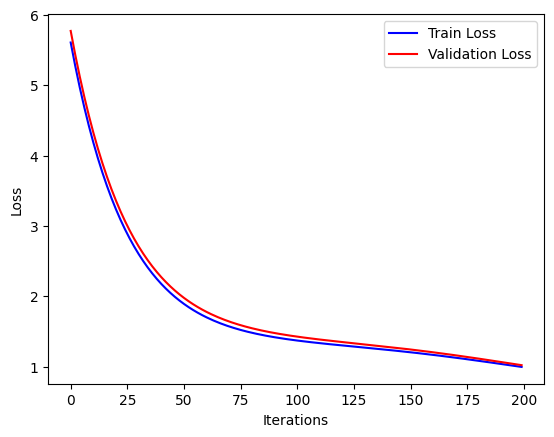

In [ ]:
plt.plot(range(0, iterations), history["train_loss"], 'b', label='Train Loss')
plt.plot(range(0, iterations), history["val_loss"], 'r', label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

 The model seems like overfitting because the there are not much different between training loss and validation loss. Training loss is not much fluctuating, its decreasing over iterations.

The validation loss shows almost same values over 100 iterations. We will try with different parameter such as :

> Will use below parameters to see the losses

* Learning_rates = [0.001, 0.01, 0.1]
* Iterations = [50,100, 150]
* hidden_neurons_list = [32, 64, 128]


In [ ]:
iterations=50
nh=32
learning_rate = 0.001
parameters, history=create_nn_model(train_features_scaled_t,train_target_scaled_t,nh, val_features_scaled_t, val_target_scaled_t, iterations, learning_rate)

iteration 0 :train_loss:5.608731746673584 val_loss5.773290634155273
iteration 1 :train_loss:5.591633319854736 val_loss5.755946636199951
iteration 2 :train_loss:5.57460355758667 val_loss5.738671779632568
iteration 3 :train_loss:5.557641506195068 val_loss5.72146463394165
iteration 4 :train_loss:5.540748119354248 val_loss5.704326629638672
iteration 5 :train_loss:5.523922443389893 val_loss5.687256336212158
iteration 6 :train_loss:5.5071635246276855 val_loss5.670253753662109
iteration 7 :train_loss:5.490470886230469 val_loss5.653319358825684
iteration 8 :train_loss:5.473845958709717 val_loss5.636451244354248
iteration 9 :train_loss:5.457287311553955 val_loss5.6196513175964355
iteration 10 :train_loss:5.440794944763184 val_loss5.602917194366455
iteration 11 :train_loss:5.4243693351745605 val_loss5.586249351501465
iteration 12 :train_loss:5.408008575439453 val_loss5.569648265838623
iteration 13 :train_loss:5.391712665557861 val_loss5.553112983703613
iteration 14 :train_loss:5.375483512878418 

In [ ]:
iterations=100
nh=64
learning_rate = 0.01
parameters, history=create_nn_model(train_features_scaled_t,train_target_scaled_t,nh, val_features_scaled_t, val_target_scaled_t, iterations, learning_rate)

iteration 0 :train_loss:5.609335899353027 val_loss5.773921966552734
iteration 1 :train_loss:5.439530849456787 val_loss5.601646423339844
iteration 2 :train_loss:5.2764716148376465 val_loss5.436166286468506
iteration 3 :train_loss:5.119887828826904 val_loss5.277209281921387
iteration 4 :train_loss:4.9695210456848145 val_loss5.124517440795898
iteration 5 :train_loss:4.825119495391846 val_loss4.97783899307251
iteration 6 :train_loss:4.686446666717529 val_loss4.836933612823486
iteration 7 :train_loss:4.553273677825928 val_loss4.701572418212891
iteration 8 :train_loss:4.425379753112793 val_loss4.571534156799316
iteration 9 :train_loss:4.302555084228516 val_loss4.446608066558838
iteration 10 :train_loss:4.184597015380859 val_loss4.326590061187744
iteration 11 :train_loss:4.0713114738464355 val_loss4.2112860679626465
iteration 12 :train_loss:3.962512969970703 val_loss4.100509166717529
iteration 13 :train_loss:3.8580222129821777 val_loss3.9940779209136963
iteration 14 :train_loss:3.757667541503

In [ ]:
iterations=150
nh=128
learning_rate = 0.1
parameters, history=create_nn_model(train_features_scaled_t,train_target_scaled_t,nh, val_features_scaled_t, val_target_scaled_t, iterations, learning_rate)

iteration 0 :train_loss:5.609528541564941 val_loss5.774062156677246
iteration 1 :train_loss:4.06143856048584 val_loss4.201159954071045
iteration 2 :train_loss:3.072239398956299 val_loss3.1920852661132812
iteration 3 :train_loss:2.4385812282562256 val_loss2.542428731918335
iteration 4 :train_loss:2.0317232608795166 val_loss2.1226489543914795
iteration 5 :train_loss:1.7693910598754883 val_loss1.849832534790039
iteration 6 :train_loss:1.5987690687179565 val_loss1.6706583499908447
iteration 7 :train_loss:1.48581862449646 val_loss1.5506752729415894
iteration 8 :train_loss:1.4085277318954468 val_loss1.4675358533859253
iteration 9 :train_loss:1.352593183517456 val_loss1.4066736698150635
iteration 10 :train_loss:1.3086457252502441 val_loss1.3584821224212646
iteration 11 :train_loss:1.2705615758895874 val_loss1.316641926765442
iteration 12 :train_loss:1.2343389987945557 val_loss1.2769951820373535
iteration 13 :train_loss:1.1974300146102905 val_loss1.2368563413619995
iteration 14 :train_loss:1.1

Out of all runs, below parameters gives the better result.
* iterations=150
* nh=128
* learning_rate = 0.1

**4. Model Evaluation (4 pts)**

Write a function to compute the Mean Absolute Percentage Error (MAPE) ( module 2 lecture, intro to feedforward neural networks, slide 21). Compute the MAPE on the test data and report the Mean Absolute Percentage Error.

Let’s use a simple linear regression model as a baseline. Create a LinearRegression model using sklearn library and fit it on the training data. Here is a quick read if you are not sure how to create a LinearRegression model in python. When you want to fit the linear regression model to the data, you need to transpose back the rows and column in your training data. In addition, you need to flatten the target array back into a 1D array. That is, suppose that the training features and target arrays that you passed to your neural network model are trainx and trainy, respectively. You can fit the linear regression model to this data as follows:

> Linear_model=LinearRegression().fit(trainx.T, trainy.flatten())


Compute the MAPE of the linear regression model you created above on the test data and compare it with the MAPE of the neural networks. Which model performs better on this dataset?

In [ ]:
def calculate_mape(actual, predicted):
  """
  Calculates the Mean Absolute Percentage Error (MAPE) between actual and predicted values.

  Args:
      actual: NumPy array of actual values.
      predicted: NumPy array of predicted values.

  Returns:
      The MAPE value.
  """
  if len(actual) != len(predicted):
    raise ValueError("Actual and predicted values must have the same length.")

  non_zero_idx = actual != 0  # Avoid division by zero
  mape = np.mean(np.abs((actual[non_zero_idx] - predicted[non_zero_idx]) / actual[non_zero_idx]) * 100)
  return mape

**Linear Regression Predictions and MAPE**

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Reshape train_target_scaled_t to match the number of samples in train_features_scaled_t
train_target_scaled_t = train_target_scaled_t.reshape(-1, 1)

# Ensure both train_features_scaled_t and train_target_scaled_t have the same number of samples
assert train_features_scaled_t.shape[1] == train_target_scaled_t.shape[0], "Mismatch in the number of samples"

# Transpose train_features_scaled_t to match dimensions
linear_model = LinearRegression().fit(train_features_scaled_t.T, train_target_scaled_t.ravel())  # Use ravel() to flatten the target
linear_predictions = linear_model.predict(test_features_scaled_t.T)

linear_mape = calculate_mape(test_target_scaled_t.ravel(), linear_predictions)  # Use ravel() to flatten the target
print("Linear Regression MAPE:", linear_mape)

Linear Regression MAPE: 30.089243516882696


**Neural Newtwork Predictions and MAPE**

In [ ]:
def neural_network_predictions(parameters, features):
    """
    Generate predictions using a trained neural network model.

    Args:
        parameters: Dictionary containing the trained neural network parameters.
        features: Input features for which predictions are needed.

    Returns:
        Predicted values.
    """


    # Perform forward pass
    Yhat = forward_pass(parameters, features)

    return Yhat

In [ ]:
learning_rates = 0.1
iterations = 150
nh = 128

# Neural Network model predictions
parameters, history = create_nn_model(train_features_scaled_t,train_target_scaled_t,nh, test_features_scaled_t, test_target_scaled_t, iterations, learning_rates)

neural_network_predictions_result=neural_network_predictions(parameters, test_features_scaled_t)

iteration 0 :train_loss:5.609055042266846 val_loss5.516300201416016
iteration 1 :train_loss:4.062067985534668 val_loss3.976081132888794
iteration 2 :train_loss:3.074052572250366 val_loss2.993528366088867
iteration 3 :train_loss:2.4424281120300293 val_loss2.366290330886841
iteration 4 :train_loss:2.0388712882995605 val_loss1.9662551879882812
iteration 5 :train_loss:1.7814375162124634 val_loss1.7116559743881226
iteration 6 :train_loss:1.617606520652771 val_loss1.5501108169555664
iteration 7 :train_loss:1.5136529207229614 val_loss1.4480029344558716
iteration 8 :train_loss:1.4479098320007324 val_loss1.3837532997131348
iteration 9 :train_loss:1.4064733982086182 val_loss1.343526840209961
iteration 10 :train_loss:1.3804426193237305 val_loss1.3184778690338135
iteration 11 :train_loss:1.3641386032104492 val_loss1.3029714822769165
iteration 12 :train_loss:1.3539530038833618 val_loss1.2934355735778809
iteration 13 :train_loss:1.3476030826568604 val_loss1.28761625289917
iteration 14 :train_loss:1.

In [ ]:
# Calculate MAPE for Neural Networks
neural_network_mape = calculate_mape(test_target_scaled_t, neural_network_predictions_result)

print("Neural Network MAPE:", neural_network_mape)

Neural Network MAPE: 60.477604


In [ ]:
# Compare which model performs better
if linear_mape < neural_network_mape:
    print("Linear Regression performs better.")
else:
    print("Neural Network performs better.")

Linear Regression performs better.
